In [ ]:
# !pip install numpy pandas xgboost scikit-optimize scikit-learn matplotlib tqdm

  Using cached numpy-2.2.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached scipy-1.15.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
Using cached numpy-2.2.3-cp312-cp312-win_amd64.whl (12.6 MB)
Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl (11.5 MB)
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---- ----------------------------------- 13.1/124.9 MB 68.7 MB/s eta 0:00:02
   -------- ------------------------------- 28.0/124.9 MB 71.1 MB/s eta 0:00:02
   ------------- -------------------------- 41.2/124.9 MB 67.2 MB/s eta 0:00:02
   ------------------ --------------------- 56.6/124.9 MB 69.4 MB/s eta 0:00:01
   ----------------------- ---------------- 73.1/124.9 MB 70.7

In [5]:
import os
import warnings
from collections import OrderedDict

import numpy as np
import pandas as pd
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import xgboost as xgb

from utils import *

This code essentially organizes and verifies your dataset structure by loading key CSV files and counting files in specific directories, making it easier to reference and use these paths in subsequent processing steps.

**Key Filepath Variables:**

- **trials_dfs['training_set']**: DataFrame for training_set's *trials.csv*  
- **trials_dfs['validation_set']**: DataFrame for validation_set's *trials.csv*  
- **trials_dfs['test_set']**: DataFrame for test_set's *trials.csv*  

- **spk2utt_dfs['training_set']**: DataFrame for training_set's *spk2utt.csv*  
- **spk2utt_dfs['validation_set']**: DataFrame for validation_set's *spk2utt.csv*  
- **spk2utt_dfs['test_set']**: DataFrame for test_set's *spk2utt.csv*  

- **folder_paths[ds][modality]['enroll_path']**: Path to the *speaker_embeddings* folder for a given dataset (ds) and modality (voiceprint or prosody)  
- **folder_paths[ds][modality]['trial_path']**: Path to the *trial_embeddings* folder for a given dataset (ds) and modality (voiceprint or prosody)

In [6]:
# === Global Configuration ===
BASE_PATH = ""

# Datasets and Modalities
DATASETS = ['training_set', 'validation_set', 'test_set']
MODALITIES = {
    'voiceprint': 'voiceprint_ecapa_tdnn',
    'prosody': 'prosody_tacotron'
}

# Storage Dictionaries
trials_dfs = {}
spk2utt_dfs = {}
folder_paths = {}

In [7]:
def count_files(folder):
    """Returns the number of files (ignoring subdirectories) in a folder."""
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

def load_csv(file_path):
    """Loads a CSV file into a DataFrame if it exists, else returns None."""
    return pd.read_csv(file_path) if os.path.exists(file_path) else None

def print_file_counts(dataset, modality, enroll_path, speaker_emb_path, trial_path):
    """Prints the number of files in given modality folders."""
    enroll_count = count_files(enroll_path) if os.path.exists(enroll_path) else 0
    speaker_emb_count = count_files(speaker_emb_path) if os.path.exists(speaker_emb_path) else 0
    trial_count = count_files(trial_path) if os.path.exists(trial_path) else 0

    print(f"{dataset} - {modality.capitalize()}:")
    print(f"    Combined speaker embeddings (enroll_path) file count: {enroll_count}")
    print(f"    Speaker embeddings (speaker_emb_path) file count: {speaker_emb_count}")
    print(f"    Trial embeddings file count: {trial_count}")

def process_dataset(dataset):
    """Processes each dataset: Loads CSVs, sets up folder paths, and prints file counts."""
    ds_data_path = os.path.join(BASE_PATH, dataset, "data")

    # Load CSV files
    trials_dfs[dataset] = load_csv(os.path.join(ds_data_path, "trials.csv"))
    spk2utt_dfs[dataset] = load_csv(os.path.join(ds_data_path, "spk2utt.csv"))

    # Initialize folder paths dictionary
    folder_paths[dataset] = {}

    # Process each modality
    for modality, folder in MODALITIES.items():
        mod_path = os.path.join(ds_data_path, folder)
        enroll_path = os.path.join(mod_path, "combined_speaker_embeddings")
        speaker_emb_path = os.path.join(mod_path, "speaker_embeddings")
        trial_path = os.path.join(mod_path, "trial_embeddings")

        # Store paths in dictionary
        folder_paths[dataset][modality] = {
            'enroll_path': enroll_path,
            'speaker_emb_path': speaker_emb_path,
            'trial_path': trial_path
        }

        # Print file counts
        print_file_counts(dataset, modality, enroll_path, speaker_emb_path, trial_path)

    # Add the feature_vector folder path
    folder_paths[dataset]["feature_vector"] = os.path.join(BASE_PATH, dataset, "feature_vector")

    # Print CSV file information
    print(f"{dataset} trials.csv shape: {trials_dfs[dataset].shape if trials_dfs[dataset] is not None else 'Not found'}")
    print(f"{dataset} spk2utt.csv shape: {spk2utt_dfs[dataset].shape if spk2utt_dfs[dataset] is not None else 'Not found'}")
    print("-" * 50)

In [8]:
for dataset in DATASETS:
    process_dataset(dataset)

# At this point:
# - 'trials_dfs' and 'spk2utt_dfs' contain the DataFrames for each dataset.
# - 'folder_paths' contains the paths to speaker embeddings and trial embeddings for each dataset and modality.

training_set - Voiceprint:
    Combined speaker embeddings (enroll_path) file count: 29
    Speaker embeddings (speaker_emb_path) file count: 343
    Trial embeddings file count: 1978
training_set - Prosody:
    Combined speaker embeddings (enroll_path) file count: 29
    Speaker embeddings (speaker_emb_path) file count: 0
    Trial embeddings file count: 1978
training_set trials.csv shape: (28710, 3)
training_set spk2utt.csv shape: (29, 2)
--------------------------------------------------
validation_set - Voiceprint:
    Combined speaker embeddings (enroll_path) file count: 25
    Speaker embeddings (speaker_emb_path) file count: 289
    Trial embeddings file count: 617
validation_set - Prosody:
    Combined speaker embeddings (enroll_path) file count: 25
    Speaker embeddings (speaker_emb_path) file count: 0
    Trial embeddings file count: 617
validation_set trials.csv shape: (1500, 3)
validation_set spk2utt.csv shape: (25, 2)
--------------------------------------------------
tes

In [9]:
# Dictionary to store loaded feature vectors and labels
dataset_dict = {}

# List of dataset types
dataset_splits = ['training_set', 'validation_set', 'test_set']

# Load features and labels for each dataset split
for split in dataset_splits:
    feature_folder = folder_paths[split]["feature_vector"]
    
    feature_path = os.path.join(feature_folder, 'features.npy')
    label_path = os.path.join(feature_folder, 'labels.npy')
    
    dataset_dict[split] = {
        'features': np.load(feature_path),
        'labels': np.load(label_path)
    }

print("Feature vectors and labels loaded successfully.")

# Assigning loaded data to variables
X_train, y_train = dataset_dict['training_set']['features'], dataset_dict['training_set']['labels']
X_val, y_val = dataset_dict['validation_set']['features'], dataset_dict['validation_set']['labels']
X_test, y_test = dataset_dict['test_set']['features'], dataset_dict['test_set']['labels']

Feature vectors and labels loaded successfully.


In [21]:
# SVM bayesian search cldnt even run without scaling

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train)

# Save the fitted scaler for later use during inference
joblib.dump(scaler, "demo-jolin/src/backend/scaler.pkl")

# Transform the validation and test data using the same scaler
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [17]:
def compute_eer(y_true, y_scores):
    """
    Compute the Equal Error Rate (EER) given true labels and predicted scores.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    # Find threshold where difference between FPR and FNR is minimal.
    eer_index = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[eer_index] + fnr[eer_index]) / 2
    return eer

## Logistic Regression Model

In [107]:
# === Step 1: Initial Training on the Training Set ===

print("Training initial Logistic Regression model...")
model_initial = LogisticRegression(solver='saga', max_iter=1000, random_state=42)

%time model_initial.fit(X_train, y_train)
print("Initial training complete.")

Training initial Logistic Regression model...
CPU times: total: 46.9 ms
Wall time: 52 ms
Initial training complete.


In [108]:
# === Step 2: Baseline Testing on the Test Set ===

print("\nEvaluating initial model on test set...")
%time test_probs_initial = model_initial.predict_proba(X_test)[:, 1]

# Compute Equal Error Rate (EER) for baseline model
eer_initial = compute_eer(y_test, test_probs_initial)
print(f"Test EER (Initial Logistic Regression Model): {eer_initial:.4f}")


Evaluating initial model on test set...
CPU times: total: 0 ns
Wall time: 1 ms
Test EER (Initial Logistic Regression Model): 0.0837


In [109]:
# === Step 3: Bayesian Optimization for Hyperparameter Tuning ===

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define the hyperparameter search space
param_search_space = {
    'C': (1e-6, 1e+6, 'log-uniform'),
    'penalty': ['l1', 'l2']
}

# Configure Bayesian search with cross-validation
bayes_search = BayesSearchCV(
    estimator=LogisticRegression(solver='saga', max_iter=1000),
    search_spaces=param_search_space,
    cv=3,  # 3-fold cross-validation
    n_iter=32,  # Number of search iterations
    scoring='roc_auc',  # Optimization metric
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)

print("\nStarting Bayesian hyperparameter search...")
%time bayes_search.fit(X_val, y_val)

# Extract best hyperparameters
best_params = bayes_search.best_params_
print(f"Best parameters found: {best_params}")


Starting Bayesian hyperparameter search...
CPU times: total: 8.97 s
Wall time: 13.6 s
Best parameters found: OrderedDict({'C': 0.9660442639182618, 'penalty': 'l2'})


In [110]:
# === Step 4: Retrain Logistic Regression Model with Optimized Parameters ===

print("\nRetraining Logistic Regression model with optimized hyperparameters...")
model_final = LogisticRegression(
    solver='saga', max_iter=1000, **best_params, random_state=42
)

%time model_final.fit(X_train, y_train)
print("Retraining complete.")


Retraining Logistic Regression model with optimized hyperparameters...
CPU times: total: 15.6 ms
Wall time: 54 ms
Retraining complete.


In [111]:
# === Step 5: Evaluate the Optimized Model on the Test Set ===

print("\nEvaluating optimized model on test set...")
%time test_probs_final = model_final.predict_proba(X_test)[:, 1]

# Compute EER for optimized model
eer_final = compute_eer(y_test, test_probs_final)
print(f"Test EER (Optimized Logistic Regression Model): {eer_final:.4f}")


Evaluating optimized model on test set...
CPU times: total: 0 ns
Wall time: 1 ms
Test EER (Optimized Logistic Regression Model): 0.0837


## XGBoost

In [114]:
# === Step 1: Initial Training on the Training Set ===

print("Training XGBoost model...")
model_initial = xgb.XGBClassifier(eval_metric='logloss')

%time model_initial.fit(X_train, y_train)
print("Initial training complete.")

Training XGBoost model...
CPU times: total: 875 ms
Wall time: 75 ms
Initial training complete.


In [115]:
# === Step 2: Evaluate Baseline XGBoost Model on Test Set ===

print("\nEvaluating initial XGBoost model on test set...")
%time test_probs_xgb_initial = model_initial.predict_proba(X_test)[:, 1]

# Compute EER for the initial XGBoost model
eer_xgb_initial = compute_eer(y_test, test_probs_xgb_initial)
print(f"Test EER (Initial XGBoost Model): {eer_xgb_initial:.4f}")


Evaluating initial XGBoost model on test set...
CPU times: total: 15.6 ms
Wall time: 16 ms
Test EER (Initial XGBoost Model): 0.0962


In [116]:
# === Step 3: Bayesian Optimization for Hyperparameter Tuning ===

# Configure warnings to ignore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

xgb_search_space = {
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42)

# Configure Bayesian optimization for hyperparameter tuning
xgb_bayes_search = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=xgb_search_space,
    n_iter=25,  # Number of search iterations
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Utilize all CPU cores
    random_state=1
)

print("\nStarting Bayesian hyperparameter search for XGBoost...")
%time xgb_bayes_search.fit(X_val, y_val)

# Extract the best hyperparameters from Bayesian search
best_xgb_params = xgb_bayes_search.best_params_
print(f"Best parameters found for XGBoost: {best_xgb_params}")


Starting Bayesian hyperparameter search for XGBoost...
CPU times: total: 8.23 s
Wall time: 10.1 s
Best parameters found for XGBoost: OrderedDict({'colsample_bytree': 0.8417787199371458, 'learning_rate': 0.031207173817042393, 'max_depth': 3, 'subsample': 0.7173875030980977})


In [117]:
# === Step 4: Retrain XGBoost Model with Optimized Parameters ===

print("\nRetraining XGBoost model with optimized hyperparameters...")
xgb_final_model = xgb.XGBClassifier(eval_metric='logloss', **best_xgb_params, random_state=1)

%time xgb_final_model.fit(X_train, y_train)
print("Retraining complete.")


Retraining XGBoost model with optimized hyperparameters...
CPU times: total: 703 ms
Wall time: 60 ms
Retraining complete.


In [ ]:
# === Step 5: Evaluate the Optimized XGBoost Model on the Test Set ===

print("\nEvaluating optimized XGBoost model on test set...")
%time test_probs_xgb_final = xgb_final_model.predict_proba(X_test)[:, 1]

# Compute EER for the optimized XGBoost model
eer_xgb_final = compute_eer(y_test, test_probs_xgb_final)
print(f"Test EER (Optimized XGBoost Model): {eer_xgb_final:.4f}")


Evaluating optimized XGBoost model on test set...
CPU times: total: 0 ns
Wall time: 5 ms
Test EER (Optimized XGBoost Model): 0.0444


## SVM

In [120]:
# === Step 1: Initial Training of SVM Model ===

print("\nTraining initial SVM model...")
model_initial = SVC(probability=True, random_state=42)

%time model_initial.fit(X_train, y_train)
print("Initial SVM training complete.")


Training initial SVM model...
CPU times: total: 9.17 s
Wall time: 9.21 s
Initial SVM training complete.


In [ ]:
# === Step 2: Baseline Testing of Initial SVM Model ===

print("\nEvaluating initial SVM model on test set...")
%time test_probs_svm_initial = model_initial.predict_proba(X_test)[:, 1]

# Compute Equal Error Rate (EER) for the initial SVM model
eer_svm_initial = compute_eer(y_test, test_probs_svm_initial)
print(f"Test EER (Initial SVM Model): {eer_svm_initial:.4f}")


Evaluating initial SVM model on test set...
CPU times: total: 1.42 s
Wall time: 1.47 s
Test EER (Initial SVM Model): 0.0373


In [132]:
# Source: https://scikit-optimize.github.io/dev/auto_examples/sklearn-gridsearchcv-replacement.html

# 'degree' parameter is excluded here (Source: https://stackoverflow.com/questions/72101295/python-gridsearchcv-taking-too-long-to-finish-running)

# === Step 3: Bayesian Optimization for Hyperparameter Tuning ===

# Configure warnings to show ConvergenceWarning only once
warnings.filterwarnings("once", category=ConvergenceWarning)

# Define SVM pipeline
svm_pipeline = Pipeline([
    ('model', SVC(cache_size=3072))
])

# Define search space for polynomial and RBF kernels
svm_poly_search_space = {
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1, 8),
    'model__kernel': Categorical(['poly']),
}

svm_rbf_search_space = {
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__kernel': Categorical(['rbf']),
}

# Initialize Bayesian search for hyperparameter tuning
svm_bayes_search = BayesSearchCV(
    estimator=svm_pipeline,
    search_spaces=[(svm_poly_search_space, 10), (svm_rbf_search_space, 10)],  # 10 iterations per search space
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Utilize all available CPU cores
    verbose=2,  # Display search progress
    random_state=42
)

print("\nStarting Bayesian hyperparameter search for SVM...")
%time svm_bayes_search.fit(X_val, y_val)

# Extract best hyperparameters from Bayesian search
best_svm_params = svm_bayes_search.best_params_

# Remove the 'model__' prefix from the parameter keys
best_svm_params = {key.split('__')[1]: value for key, value in best_svm_params.items()}

print(f"Best parameters found for SVM: {best_svm_params}")


Starting Bayesian hyperparameter search for SVM...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitt

<Axes: >

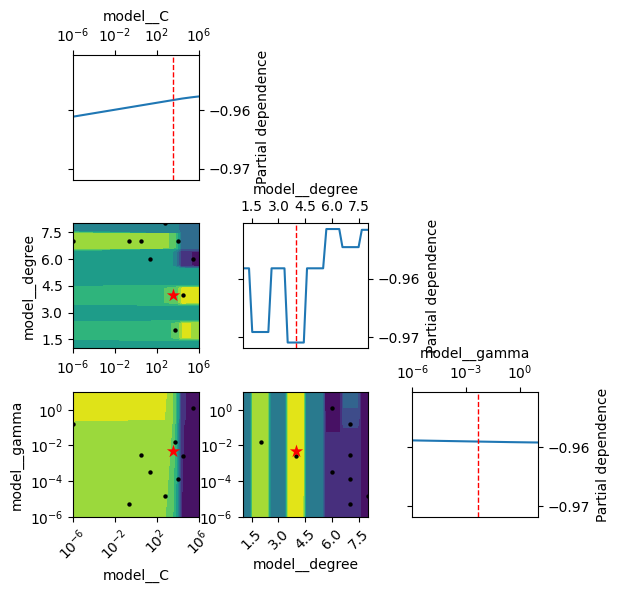

In [133]:
# Visualize optimization results
plot_objective(svm_bayes_search.optimizer_results_[0])

In [142]:
# === Step 4: Retrain SVM Model with Optimized Parameters ===

print("\nRetraining SVM model with optimized hyperparameters...")
model_final = SVC(probability=True, **best_svm_params, random_state=100)

%time model_final.fit(X_train, y_train)
print("Retraining complete.")


Retraining SVM model with optimized hyperparameters...
CPU times: total: 7.14 s
Wall time: 7.14 s
Retraining complete.


In [ ]:
# === Step 5: Evaluate the Optimized SVM Model on the Test Set ===

print("\nEvaluating optimized SVM model on test set...")
%time test_probs_svm_final = model_final.predict_proba(X_test)[:, 1]

# Compute EER for the optimized SVM model
eer_svm_final = compute_eer(y_test, test_probs_svm_final)
print(f"Test EER (Optimized SVM Model): {eer_svm_final:.4f}")


Evaluating optimized SVM model on test set...
CPU times: total: 1.33 s
Wall time: 1.33 s
Test EER (Optimized SVM Model): 0.0353


## Summary of Results

In [ ]:
# to include ROC curve, fpr n tpr plotting and confusion matrix

# https://www.kaggle.com/code/alimtleuliyev/speaker-verification-evaluation

## Save best model

In [2]:
import joblib

In [ ]:
# Save the model to a file named 'model_final.pkl'
joblib.dump(model_final, "demo-jolin/src/backend/model_final.pkl")

In [4]:
# Later, you can load the model like this:
model_loaded = joblib.load("demo-jolin/src/backend/model_final.pkl")

In [15]:
X_test[1].reshape(1, -1)

array([[ 1.30594878, -2.72319102, -0.34644538, -0.94447626, -2.72319102,
         4.01368339]])

In [16]:
# Use the loaded model for predictions
# For example, if you have new data X_new:
predictions = model_loaded.predict(X_test[1].reshape(1, -1))

# If you need class probabilities (and you had set probability=True):
probabilities = model_loaded.predict_proba(X_test[1].reshape(1, -1))

print("Predictions:", predictions)
print("Probabilities:", probabilities)

Predictions: [1]
Probabilities: [[7.11070878e-08 9.99999929e-01]]


In [20]:
int(predictions[0])

1